In [49]:
#Dependecies 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

# Python Api Dependencies
import requests
import json
from pprint import pprint
import hvplot.pandas
from scipy.stats import linregress
# conda install -c conda-forge geopandas
import geopandas as gpd
# pip install pycountry
import pycountry
from mplcursors import cursor  # separate package must be installed

# Import the API key
from api_keys import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the WHR_2023 data
whr_df = pd.read_csv("../Resources/WHR_2023.csv")
whr_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


In [3]:
#rename columns
whr_df.columns = ["Country", "Year", "Happiness Score", "GDP p/capita", "Social Support",
                  "Healthy Life Expectancy", "Life Choices Freedom", "Generosity",
                  "Corruption Perceptions", "Positive Affect", "Negative Effect"]
whr_df.head()

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


In [4]:
# Extract years that we are woprking with 
whr_clean_df = whr_df.loc[whr_df["Year"] >= 2016]
whr_clean_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.044,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.119,0.954,0.435,0.371
10,Afghanistan,2018,2.694,7.631,0.508,53.575,0.374,-0.091,0.928,0.385,0.405
11,Afghanistan,2019,2.375,7.640,0.420,53.900,0.394,-0.106,0.924,0.324,0.502
12,Afghanistan,2021,2.436,7.324,0.454,54.550,0.394,-0.081,0.946,0.179,0.607
...,...,...,...,...,...,...,...,...,...,...,...
2194,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212
2195,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831,0.658,0.235
2196,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
2197,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


In [5]:
#group by year the clean df
grouped_clean_df = whr_clean_df.groupby(["Year"]).mean()
grouped_clean_df

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2016,5.396447,9.389850,0.811922,63.432117,0.762921,-0.002223,0.747277,0.655830,0.285234
2017,5.460408,9.389575,0.805144,63.570979,0.780603,-0.009007,0.728540,0.648336,0.291212
2018,5.498674,9.390922,0.812170,63.890399,0.783843,-0.028759,0.734571,0.652604,0.292914
2019,5.570965,9.453196,0.816895,64.162590,0.794683,-0.023979,0.723267,0.654585,0.286838
2020,5.727517,9.632044,0.823009,65.541814,0.809800,-0.005325,0.726082,0.664391,0.301704
2021,5.636246,9.596425,0.803959,65.409664,0.788099,0.035417,0.724866,0.653123,0.290180
2022,5.585140,9.523074,0.798009,65.286712,0.790434,0.028491,0.720838,0.656465,0.292491


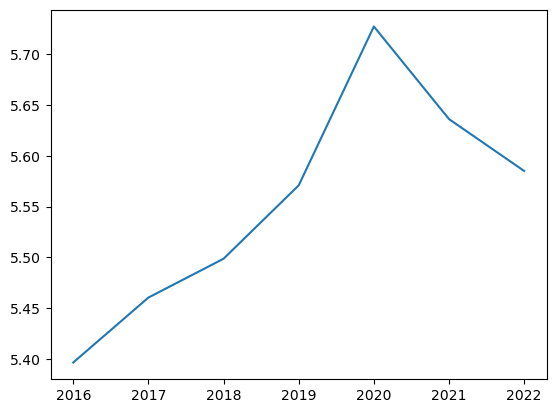

In [6]:
#plot hapiness score over time 2016-2022
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["Happiness Score"]
plt.plot(x_axis, y_axis)
plt.xticks(grouped_clean_df.index)
plt.show()

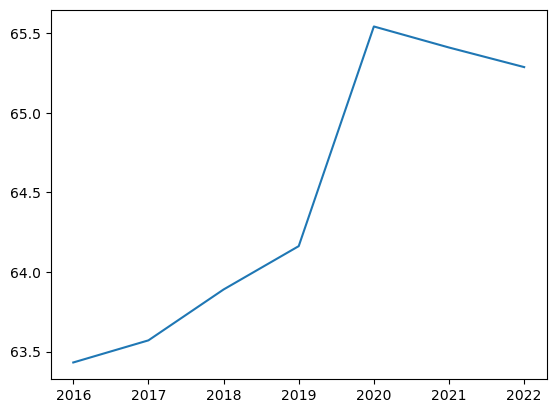

In [7]:
#plot Healthy Life Expectancy score over time 2016-2022
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["Healthy Life Expectancy"]
plt.plot(x_axis, y_axis)
plt.xticks(grouped_clean_df.index)
plt.show()

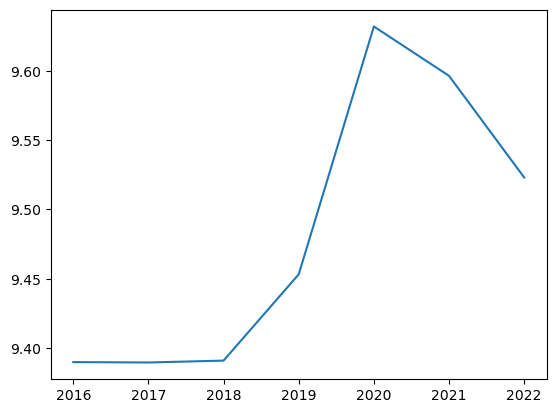

In [8]:
#plot GDP score over time 2016-2022
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["GDP p/capita"]
plt.plot(x_axis, y_axis)
plt.xticks(grouped_clean_df.index)
plt.show()

In [9]:
# create a new df for pre-pandemic (2016-2019) 
pre_covid_df = whr_clean_df.loc[whr_clean_df["Year"] <= 2019]
pre_covid_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.044,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.119,0.954,0.435,0.371
10,Afghanistan,2018,2.694,7.631,0.508,53.575,0.374,-0.091,0.928,0.385,0.405
11,Afghanistan,2019,2.375,7.640,0.420,53.900,0.394,-0.106,0.924,0.324,0.502
22,Albania,2016,4.511,9.417,0.638,69.025,0.730,-0.019,0.901,0.567,0.322
...,...,...,...,...,...,...,...,...,...,...,...
2179,Zambia,2019,3.307,8.123,0.638,54.400,0.811,0.078,0.832,0.674,0.394
2192,Zimbabwe,2016,3.735,7.735,0.768,51.675,0.733,-0.079,0.724,0.685,0.209
2193,Zimbabwe,2017,3.638,7.754,0.754,52.150,0.753,-0.081,0.751,0.734,0.224
2194,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212


In [10]:
#create a post-pandemic data frame 
post_covid_df = whr_clean_df.loc[whr_clean_df["Year"] >= 2020]
post_covid_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
12,Afghanistan,2021,2.436,7.324,0.454,54.550,0.394,-0.081,0.946,0.179,0.607
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
26,Albania,2020,5.365,9.492,0.710,69.125,0.754,0.004,0.891,0.563,0.265
27,Albania,2021,5.255,9.583,0.702,69.150,0.827,0.041,0.896,0.554,0.254
28,Albania,2022,5.212,9.626,0.724,69.175,0.802,-0.066,0.846,0.547,0.255
...,...,...,...,...,...,...,...,...,...,...,...
2180,Zambia,2020,4.838,8.066,0.767,54.825,0.750,0.058,0.810,0.679,0.345
2181,Zambia,2021,3.082,8.082,0.619,55.250,0.833,0.141,0.824,0.656,0.349
2196,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
2197,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


In [11]:
# group post_covid_df by year and calculate mean of parameters 
grouped_post_covid = post_covid_df.groupby(["Year"]).mean()
grouped_post_covid

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2020,5.727517,9.632044,0.823009,65.541814,0.809800,-0.005325,0.726082,0.664391,0.301704
2021,5.636246,9.596425,0.803959,65.409664,0.788099,0.035417,0.724866,0.653123,0.290180
2022,5.585140,9.523074,0.798009,65.286712,0.790434,0.028491,0.720838,0.656465,0.292491


In [12]:
# group pre_covid_df bu year and calculate mean of parameters 
grouped_pre_covid = pre_covid_df.groupby(["Year"]).mean()
pre_covid = pd.DataFrame(grouped_pre_covid)
pre_covid

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2016,5.396447,9.389850,0.811922,63.432117,0.762921,-0.002223,0.747277,0.655830,0.285234
2017,5.460408,9.389575,0.805144,63.570979,0.780603,-0.009007,0.728540,0.648336,0.291212
2018,5.498674,9.390922,0.812170,63.890399,0.783843,-0.028759,0.734571,0.652604,0.292914
2019,5.570965,9.453196,0.816895,64.162590,0.794683,-0.023979,0.723267,0.654585,0.286838


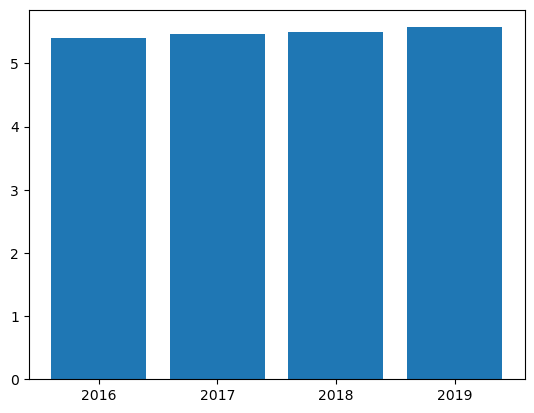

In [13]:
# plot test 

x_axis = pre_covid.index
y_axis = pre_covid["Happiness Score"]
plt.bar(x_axis, y_axis)
plt.xticks(pre_covid.index)
plt.show()

In [14]:
# read the depression file 
depression_df = pd.read_csv("../Resources/depression-rates-by-country-2023.csv")
depression_df.head()

,country,prevalence,cases,pop2023
0,Ukraine,6.3,2800587,36744634.0
1,United States,5.9,17491047,339996563.0
2,Australia,5.9,1318599,26439111.0
3,Estonia,5.9,75667,1322765.0
4,Brazil,5.8,11548577,216422446.0


In [15]:
# rename columns 
depression_df.columns = ["Country", "% of Pop with Depression", "Cases", "Pop-2023"]
depression_df

,Country,% of Pop with Depression,Cases,Pop-2023
0,Ukraine,6.3,2800587,36744634.0
1,United States,5.9,17491047,339996563.0
2,Australia,5.9,1318599,26439111.0
3,Estonia,5.9,75667,1322765.0
4,Brazil,5.8,11548577,216422446.0
...,...,...,...,...
175,Kiribati,3.1,3452,133515.0
176,Micronesia,3.1,3182,115224.0
177,Papua New Guinea,3.0,223094,10329931.0
178,Timor-Leste,3.0,33932,1360596.0


In [16]:
# Python API
# Create a dataframe for the country and longitue/latitude
params = {
    "apiKey": geoapify_key
}

# Build URL using the geocode endpoint
base_url = "https://api.geoapify.com/v1/geocode/search"

country_data = []

country_list = whr_clean_df["Country"].unique()
print(f"There are {len(country_list)} countries in total.")

# Go through list of countries to get coordinates
for country in country_list:
    params["country"] = country
    
    # Run request
    response = requests.get(base_url, params=params).json()
    
    try:
        lat = response['features'][0]['properties']['lat']
        long = response['features'][0]['properties']['lon']
        a2code = response['features'][0]['properties']['country_code']
        country_py = pycountry.countries.get(alpha_2=a2code)
        a3code = country_py.alpha_3
    except:
        pass
        
    country_data.append({"Country": country,
                        "Latitude": lat,
                        "Longitude":long,
                        "Code_A3" : a3code.upper()})
    

country_df = pd.DataFrame(country_data)
country_df

There are 153 countries in total.


,Country,Latitude,Longitude,Code_A3
0,Afghanistan,33.768006,66.238514,AFG
1,Albania,41.000028,19.999962,ALB
2,Algeria,28.000027,2.999983,DZA
3,Argentina,-34.996496,-64.967282,ARG
4,Armenia,40.769627,44.673665,ARM
...,...,...,...,...
148,Venezuela,8.001871,-66.110932,VEN
149,Vietnam,15.926666,107.965086,VNM
150,Yemen,16.347124,47.891527,YEM
151,Zambia,-14.518912,27.558988,ZMB


In [17]:
#Show the participating countries
# Configure the map plot
country_map_plot = country_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "ESRI",
    frame_width = 800,
    frame_height = 600,
    #size = "Humidity",
    scale = 0.5,
    color = "Country"

)

# Display the map
country_map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country)

In [18]:
# Save original dataframe to a working dataframe
world_happiness_df = whr_clean_df
world_happiness_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.044,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.119,0.954,0.435,0.371
10,Afghanistan,2018,2.694,7.631,0.508,53.575,0.374,-0.091,0.928,0.385,0.405
11,Afghanistan,2019,2.375,7.640,0.420,53.900,0.394,-0.106,0.924,0.324,0.502
12,Afghanistan,2021,2.436,7.324,0.454,54.550,0.394,-0.081,0.946,0.179,0.607
...,...,...,...,...,...,...,...,...,...,...,...
2194,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212
2195,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831,0.658,0.235
2196,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
2197,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


In [19]:
# Create Happiness average score per country
whr_clean_group_df = whr_clean_df.groupby("Country").mean()
# Merge the two DataFrames, WHR and Country coordinates, together based on the Country Name they share
merged_country_happiness_df = pd.merge(whr_clean_group_df, country_df, on=["Country"])
merged_country_happiness_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect,Latitude,Longitude,Code_A3
0,Afghanistan,2018.833333,2.611333,7.578600,0.443333,53.845833,0.413333,-0.070600,0.879667,0.338333,0.468167,33.768006,66.238514,AFG
1,Albania,2019.000000,4.997429,9.513143,0.683143,69.100000,0.780571,-0.023571,0.889000,0.559714,0.289000,41.000028,19.999962,ALB
2,Algeria,2018.500000,5.172167,9.348500,0.811167,66.350000,0.507400,-0.111200,0.727200,0.536667,0.290500,28.000027,2.999983,DZA
3,Argentina,2019.000000,6.059286,10.004286,0.894000,67.100000,0.830000,-0.154571,0.831286,0.714571,0.316429,-34.996496,-64.967282,ARG
4,Armenia,2018.833333,4.974333,9.513167,0.762667,67.054167,0.743667,-0.164167,0.742667,0.539500,0.464333,40.769627,44.673665,ARM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Venezuela,2019.000000,4.975714,6.251750,0.869857,64.400000,0.615571,0.049500,0.833429,0.709571,0.365286,8.001871,-66.110932,VEN
149,Vietnam,2019.000000,5.467000,9.204286,0.833167,65.300000,0.928667,-0.053667,0.781167,0.647167,0.212333,15.926666,107.965086,VNM
150,Yemen,2017.500000,3.583750,7.421750,0.806000,57.837500,0.583000,-0.123000,0.795500,0.414750,0.262750,16.347124,47.891527,YEM
151,Zambia,2018.500000,3.924833,8.111167,0.708833,54.187500,0.803333,0.097833,0.798000,0.669833,0.366333,-14.518912,27.558988,ZMB


In [20]:
# Merge the two DataFrames, WHR with coordinates and Depression data, together based on the Country Name they share
#
# IMPORTANT NOTE: Depression rate was dated 2023 ???
#
happiness_depression_df = pd.merge(merged_country_happiness_df, depression_df, on=["Country"])
happiness_depression_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect,Latitude,Longitude,Code_A3,% of Pop with Depression,Cases,Pop-2023
0,Afghanistan,2018.833333,2.611333,7.578600,0.443333,53.845833,0.413333,-0.070600,0.879667,0.338333,0.468167,33.768006,66.238514,AFG,3.3,1038610,42239854.0
1,Albania,2019.000000,4.997429,9.513143,0.683143,69.100000,0.780571,-0.023571,0.889000,0.559714,0.289000,41.000028,19.999962,ALB,4.8,131048,2832439.0
2,Algeria,2018.500000,5.172167,9.348500,0.811167,66.350000,0.507400,-0.111200,0.727200,0.536667,0.290500,28.000027,2.999983,DZA,4.5,1683914,45606480.0
3,Argentina,2019.000000,6.059286,10.004286,0.894000,67.100000,0.830000,-0.154571,0.831286,0.714571,0.316429,-34.996496,-64.967282,ARG,4.7,1914354,45773884.0
4,Armenia,2018.833333,4.974333,9.513167,0.762667,67.054167,0.743667,-0.164167,0.742667,0.539500,0.464333,40.769627,44.673665,ARM,5.0,142712,2777970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Venezuela,2019.000000,4.975714,6.251750,0.869857,64.400000,0.615571,0.049500,0.833429,0.709571,0.365286,8.001871,-66.110932,VEN,4.2,1270099,28838499.0
140,Vietnam,2019.000000,5.467000,9.204286,0.833167,65.300000,0.928667,-0.053667,0.781167,0.647167,0.212333,15.926666,107.965086,VNM,4.0,3564934,98858950.0
141,Yemen,2017.500000,3.583750,7.421750,0.806000,57.837500,0.583000,-0.123000,0.795500,0.414750,0.262750,16.347124,47.891527,YEM,3.6,915231,34449825.0
142,Zambia,2018.500000,3.924833,8.111167,0.708833,54.187500,0.803333,0.097833,0.798000,0.669833,0.366333,-14.518912,27.558988,ZMB,4.0,636819,20569737.0


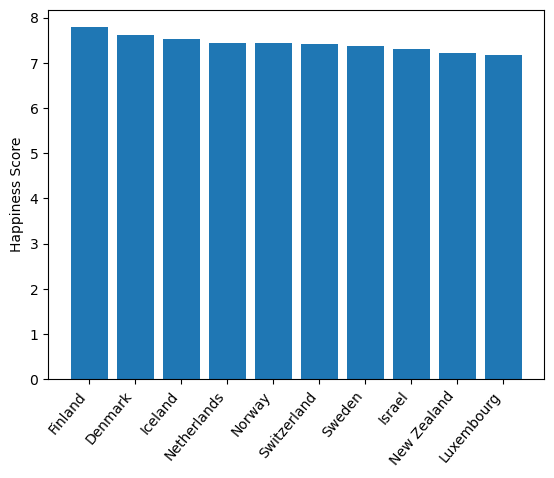

In [21]:
# Display top 10 countries with highest Happiness Score
happiness_depression_df = happiness_depression_df.sort_values("Happiness Score", ascending=False)
country_happiness_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_happiness_df.index
y_axis = country_happiness_df["Happiness Score"]
plt.bar(x_axis, y_axis)
plt.xticks(country_happiness_df.index, rotation=50, ha="right")
plt.ylabel("Happiness Score")
plt.show()


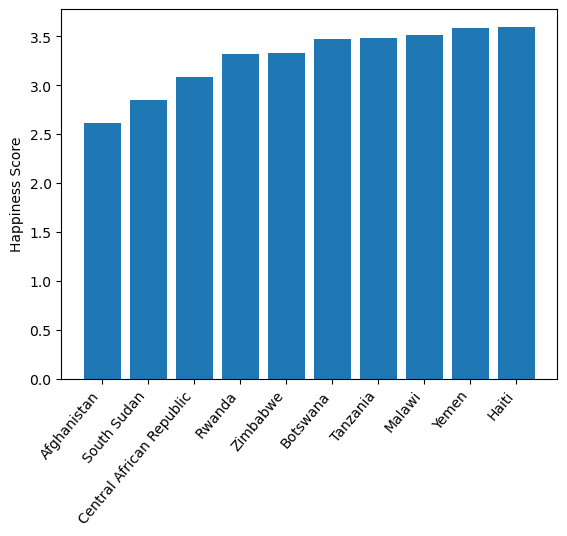

In [22]:
# Display top 10 countries with lowest Happiness Score
happiness_depression_df = happiness_depression_df.sort_values("Happiness Score")
country_happiness_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_happiness_df.index
y_axis = country_happiness_df["Happiness Score"]
plt.bar(x_axis, y_axis)
plt.xticks(country_happiness_df.index, rotation=50, ha="right")
plt.ylabel("Happiness Score")
plt.show()

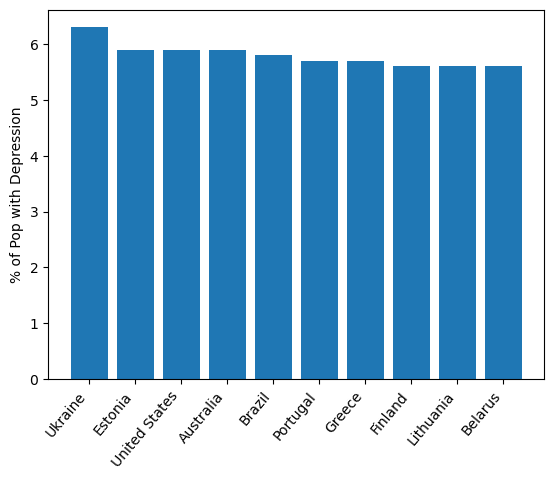

In [23]:
# Display top 5 countries with highest depression
happiness_depression_df = happiness_depression_df.sort_values("% of Pop with Depression", ascending=False)
country_depression_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_depression_df.index
y_axis = country_depression_df["% of Pop with Depression"]
plt.bar(x_axis, y_axis)
plt.xticks(country_depression_df.index, rotation=50, ha="right")
plt.ylabel("% of Pop with Depression")
plt.show()


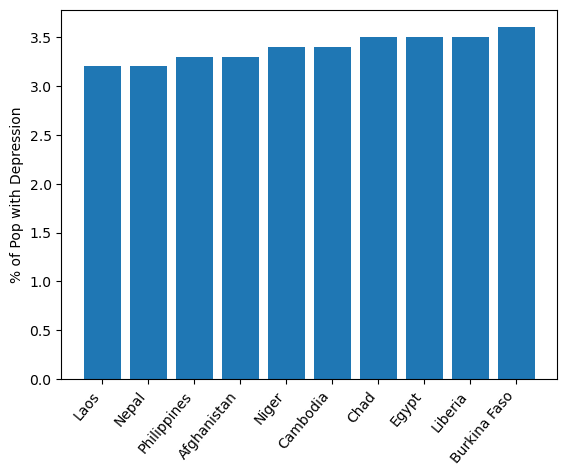

In [24]:
# Display top 5 countries with lowest depression
happiness_depression_df = happiness_depression_df.sort_values("% of Pop with Depression")
country_depression_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_depression_df.index
y_axis = country_depression_df["% of Pop with Depression"]
plt.bar(x_axis, y_axis)
plt.xticks(country_depression_df.index, rotation=50, ha="right")
plt.ylabel("% of Pop with Depression")
plt.show()


# Show plot based on lacation and the happiness score/% of population with depression (side by side) marked by color intensity

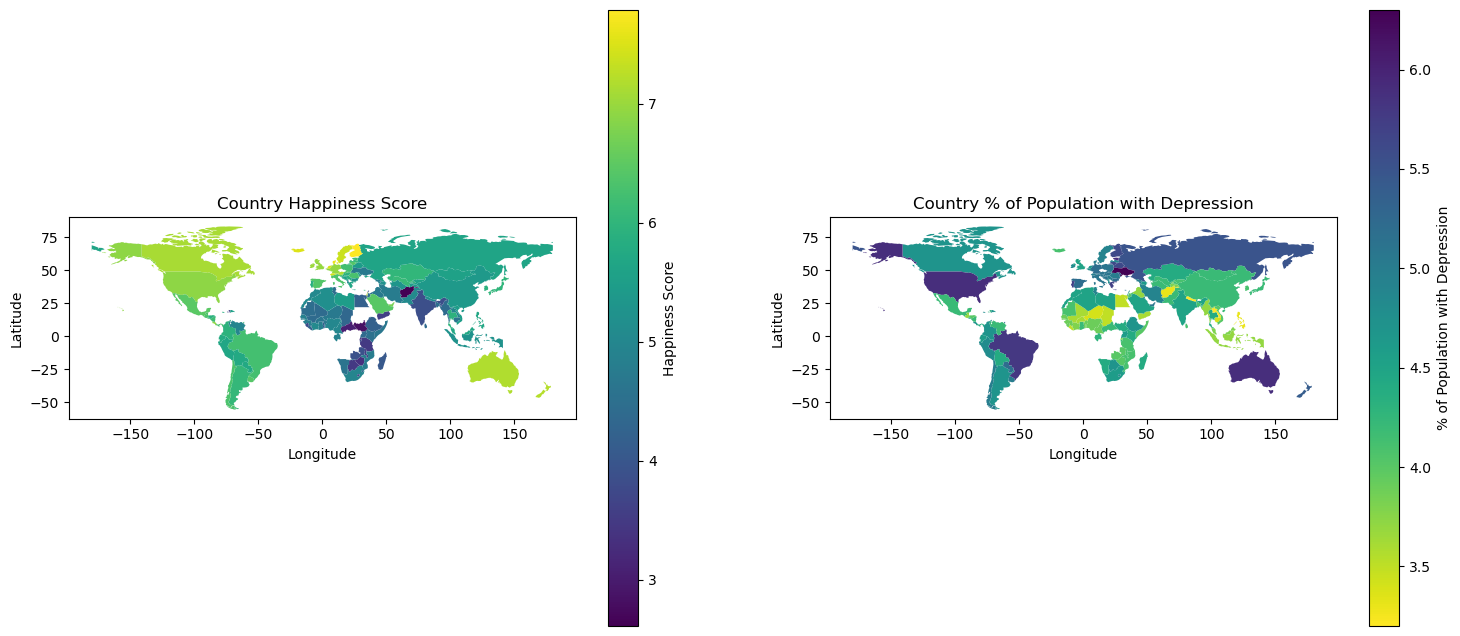

In [46]:

# Read country map images
world_maps = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the map data
world_happiness_merged = world_maps.merge(happiness_depression_df, left_on='iso_a3', right_on='Code_A3')

# Plot the map with colored tiles
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

world_happiness_merged.plot(column='Happiness Score', cmap='viridis', linewidth=0.4, ax=ax[0], legend=True, legend_kwds={'label': "Happiness Score"})
ax[0].set_title('Country Happiness Score')
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")

# world_happiness_merged contains depression data too
world_depression_merged = world_happiness_merged


# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('viridis')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

world_depression_merged.plot(column='% of Pop with Depression', cmap=reversed_map, linewidth=0.4, ax=ax[1], legend=True, legend_kwds={'label': "% of Population with Depression"})
ax[1].set_title('Country % of Population with Depression')
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")

plt.show()

# Show plot based on lacation and the happiness score marked by color intensity

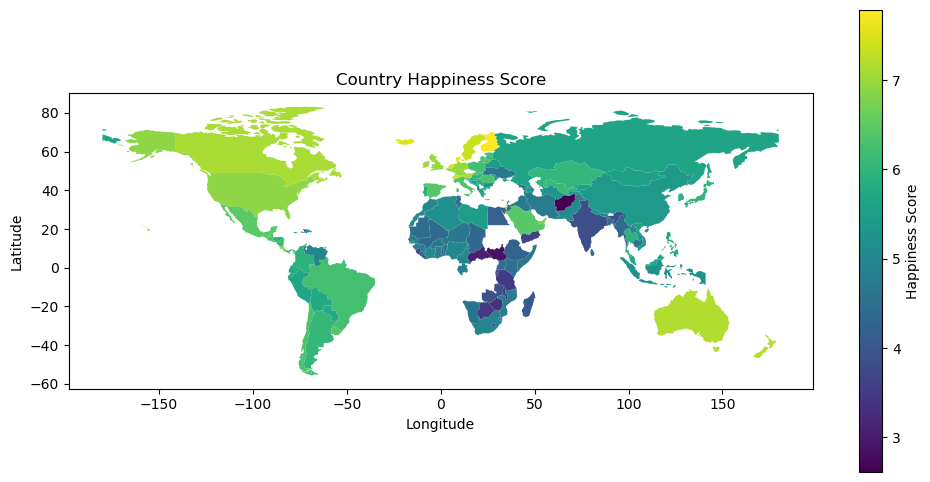

In [51]:

# Read country map images
world_maps = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the map data
world_happiness_merged = world_maps.merge(happiness_depression_df, left_on='iso_a3', right_on='Code_A3')

# Plot the map with colored tiles
fig, ax = plt.subplots(1, figsize=(12, 6))

world_happiness_merged.plot(column='Happiness Score', cmap='viridis', linewidth=0.4, ax=ax, legend=True, legend_kwds={'label': "Happiness Score"})
ax.set_title('Country Happiness Score')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
plt.show()

# Show plot based on lacation and the % of Population with Depression score marked by color intensity

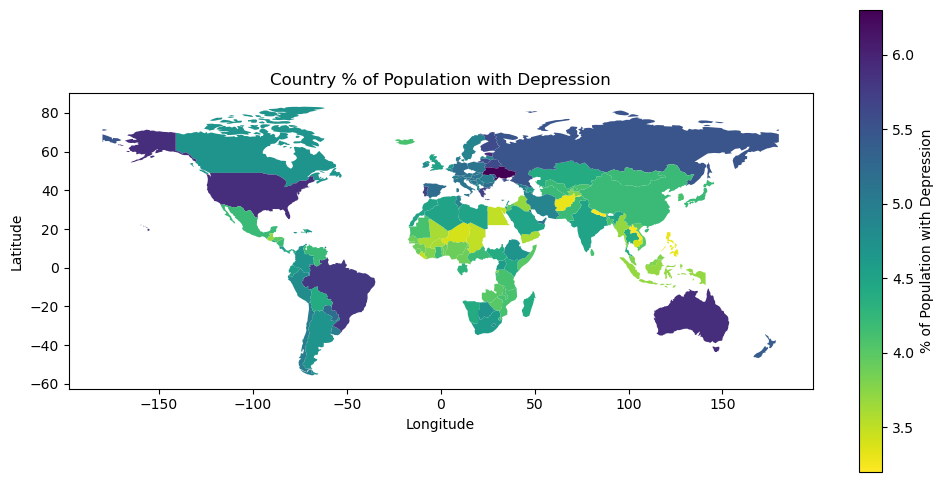

In [26]:
# Use previously read country map images

# world_happiness_merged contains depression data too
world_depression_merged = world_happiness_merged

# Plot the map with colored tiles
fig, ax = plt.subplots(1, figsize=(12, 6))

# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('viridis')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

world_depression_merged.plot(column='% of Pop with Depression', cmap=reversed_map, linewidth=0.4, ax=ax, legend=True, legend_kwds={'label': "% of Population with Depression"})
ax.set_title('Country % of Population with Depression')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
plt.show()

# Display Happiness Score in box plots for Finland(top), Afghanistan(bottom) & Australia

Afghanistan potential outliers: 5    1.281
Name: Score, dtype: float64
Albania potential outliers: Series([], Name: Score, dtype: float64)
Algeria potential outliers: Series([], Name: Score, dtype: float64)
Argentina potential outliers: Series([], Name: Score, dtype: float64)
Armenia potential outliers: Series([], Name: Score, dtype: float64)
Australia potential outliers: Series([], Name: Score, dtype: float64)
Austria potential outliers: Series([], Name: Score, dtype: float64)
Azerbaijan potential outliers: Series([], Name: Score, dtype: float64)
Bahrain potential outliers: Series([], Name: Score, dtype: float64)
Bangladesh potential outliers: Series([], Name: Score, dtype: float64)
Belarus potential outliers: Series([], Name: Score, dtype: float64)
Belgium potential outliers: Series([], Name: Score, dtype: float64)
Benin potential outliers: Series([], Name: Score, dtype: float64)
Bolivia potential outliers: Series([], Name: Score, dtype: float64)
Bosnia and Herzegovina potential outl

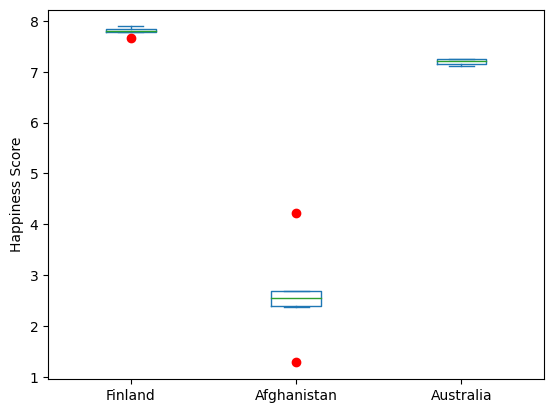

In [27]:
# Display box plots for 3 countries to show happiness outliers (Australia, Finland, Afghanistan)
happiness_df = pd.DataFrame()

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for country in country_list:

    # Locate the rows for specific countries and get Happiness Score
    score = world_happiness_df.loc[world_happiness_df["Country"]==country, "Happiness Score"]

    # add subset 
    happiness_df["Score"] = pd.DataFrame(score.tolist())
    happiness_df[country] = pd.DataFrame(score.tolist())
    
    # Determine outliers using upper and lower bounds
    quartiles = happiness_df["Score"].quantile([0.25,0.5,0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    outliers = happiness_df.loc[happiness_df["Score"]<lower_bound, "Score"]
    print(f"{country} potential outliers: {outliers}")


ax = happiness_df[["Finland", "Afghanistan", "Australia"]].plot(kind='box', sym='r')

ax.set_ylabel('Happiness Score')
plt.show()



In [28]:
# Create Happiness average score per year for all countries to represent the world
average_happiness_year_df = world_happiness_df.groupby("Year").mean()
average_happiness_year_df.head()


,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2016,5.396447,9.389850,0.811922,63.432117,0.762921,-0.002223,0.747277,0.655830,0.285234
2017,5.460408,9.389575,0.805144,63.570979,0.780603,-0.009007,0.728540,0.648336,0.291212
2018,5.498674,9.390922,0.812170,63.890399,0.783843,-0.028759,0.734571,0.652604,0.292914
2019,5.570965,9.453196,0.816895,64.162590,0.794683,-0.023979,0.723267,0.654585,0.286838
2020,5.727517,9.632044,0.823009,65.541814,0.809800,-0.005325,0.726082,0.664391,0.301704


# Display Hppiness Score box plot for World,Australia, Finland

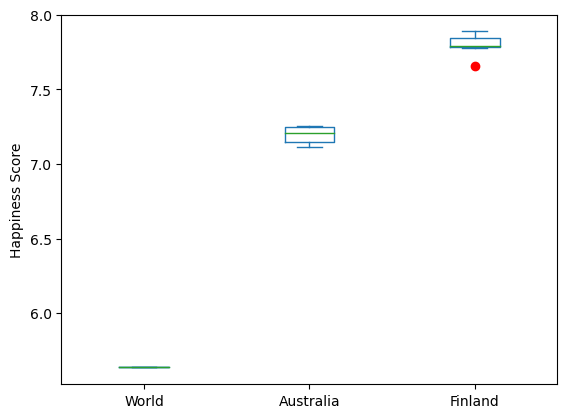

In [32]:
# Create box plots to compare the World, Australia and Finland
index = 0
for row in list(happiness_df["Finland"]):
    happiness_df["World"] = average_happiness_year_df.iloc[index, 0]
    index = index + 1
    

ax = happiness_df[["World", "Australia", "Finland"]].plot(kind='box', sym='r')
ax.set_ylabel('Happiness Score')

plt.show()

In [33]:
# Define a function to create Linear Regression plots
def plot_linear_regression(main_df, xcolumn_str, ycolumn_str):

    # Drop rows with null
    main_df = main_df.dropna()
    
    x_values = main_df[xcolumn_str]
    y_values = main_df[ycolumn_str]
    # Build the scatter plots 
    plt.scatter(x_values, y_values, marker='o', c=y_values)

    # Incorporate the other graph properties
    plt.title(f"{xcolumn_str} vs. {ycolumn_str}")
    plt.ylabel(ycolumn_str)
    plt.xlabel(xcolumn_str)

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

    plt.plot(x_values,regress_values,"r-")

    # Label plot and annotate the line equation
    x = x_values.min()
    y = y_values.min()
    plt.annotate(line_eq,(x, y),fontsize=15,color="red")

    # Print r value
    print(f"The r-value is: {rvalue**2}")

    # Show plot
    plt.show()

    return

# GDP p/capita vs Happiness Score

The r-value is: 0.668867993905691


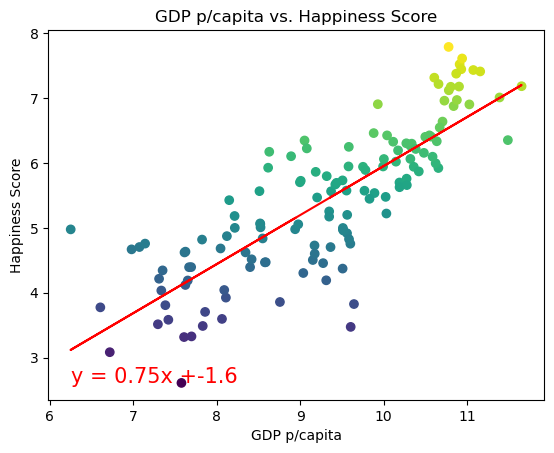

In [34]:
# Plot GDP vs Happiness Score
plot_linear_regression(happiness_depression_df, "GDP p/capita", "Happiness Score")


#### GDP p/capita vs Happiness Score has a moderate correlation.

# GDP p/capita vs % of Pop with Depression

The r-value is: 0.40482934977699564


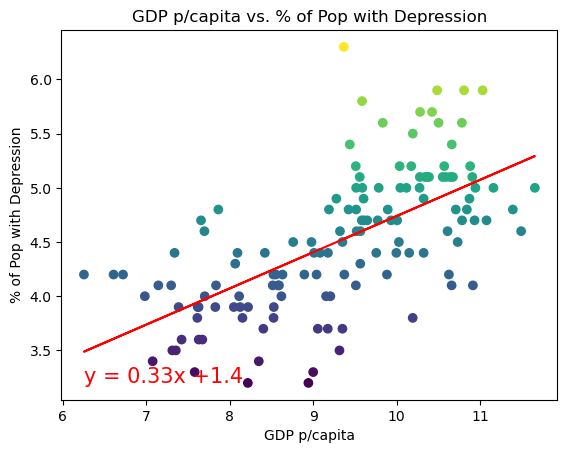

In [35]:
# Plot GDP vs Depression %
plot_linear_regression(happiness_depression_df, "GDP p/capita", "% of Pop with Depression")


#### GDP p/capita vs % of Pop with Depression has a weak correlation.

# Happiness Score vs % of Population with Depression

The r-value is: 0.2583165246974504


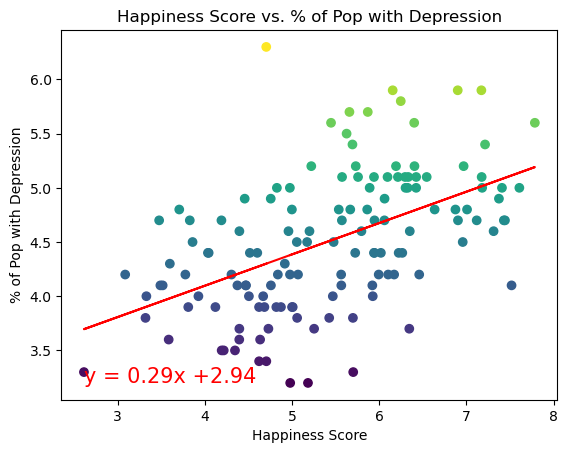

In [36]:
# Plot GDP vs Depression %
plot_linear_regression(happiness_depression_df, "Happiness Score", "% of Pop with Depression")

#### Happiness vs % of Population with Depression has very weak or no correlation at all.